In [1]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from river import tree, metrics, compose, preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

In [2]:
# Load the preprocessed CSV file
file_path = os.path.join("processed_data", "preprocessed_dataset.csv")
df = pd.read_csv(file_path)

print("Shape of the dataset:", df.shape)

Shape of the dataset: (1019035, 79)


In [3]:
# X and y from full dataset
X_all = df.drop(columns=['Label'])
y_all = df['Label']

# Scale dataset before selecting features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_all)

# Select top k features
k = 12  
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y_all)

# Save selected features
selected_mask = selector.get_support()
selected_features_kbest = X_all.columns[selected_mask].tolist()
print("Selected Features by SelectKBest:", selected_features_kbest)

d:\multiclass-incremental-ids\ids-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\multiclass-incremental-ids\ids-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected Features by SelectKBest: ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Max', 'Packet Length Std', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']


In [4]:
# Save new DataFrame with selected features
df_kbest = df[selected_features_kbest + ['Label']]
# Split into train and test set
train_df, test_df = train_test_split(df_kbest, test_size=0.2, random_state=42, stratify=df_kbest['Label'])

In [5]:
# Create model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeClassifier()
)

In [6]:
# Load label mapping
with open('processed_data/label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

In [7]:
# Training phase
acc = metrics.Accuracy()
precision = metrics.MacroPrecision()
recall = metrics.MacroRecall()
f1 = metrics.MacroF1()
cm = metrics.ConfusionMatrix()

class_metrics = {
    'accuracy': defaultdict(list),
    'precision': defaultdict(list),
    'recall': defaultdict(list)
}
class_counts = defaultdict(int)
correct_preds = defaultdict(int)
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

steps = []
step_count = 0

for _, row in train_df.iterrows():
    x = row[selected_features_kbest].to_dict()
    y = row['Label']
    y_pred = model.predict_one(x)

    if y_pred is not None:
        acc.update(y, y_pred)
        precision.update(y, y_pred)
        recall.update(y, y_pred)
        f1.update(y, y_pred)
        cm.update(y, y_pred)

        class_counts[y] += 1
        if y == y_pred:
            correct_preds[y] += 1

        for label in label_mapping.values():
            if y_pred == label and y == label:
                tp[label] += 1
            elif y_pred == label and y != label:
                fp[label] += 1
            elif y_pred != label and y == label:
                fn[label] += 1

        step_count += 1
        if step_count % 1000 == 0:
            steps.append(step_count)
            for label_name, label_val in label_mapping.items():
                acc_val = correct_preds[label_val] / class_counts[label_val] if class_counts[label_val] > 0 else 0
                prec_val = tp[label_val] / (tp[label_val] + fp[label_val]) if (tp[label_val] + fp[label_val]) > 0 else 0
                rec_val = tp[label_val] / (tp[label_val] + fn[label_val]) if (tp[label_val] + fn[label_val]) > 0 else 0

                class_metrics['accuracy'][label_name].append(acc_val)
                class_metrics['precision'][label_name].append(prec_val)
                class_metrics['recall'][label_name].append(rec_val)

    model.learn_one(x, y)

print("Training Results:")
print("Accuracy:", acc)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1-score (Macro):", f1)
print("Confusion Matrix:\n", cm)

Training Results:
Accuracy: Accuracy: 92.15%
Precision (Macro): MacroPrecision: 89.63%
Recall (Macro): MacroRecall: 88.12%
F1-score (Macro): MacroF1: 88.81%
Confusion Matrix:
       0.0       1.0      2.0       3.0     
0.0   484,526    7,326     1,730    8,298  
1.0    13,261   80,400     7,795      957  
2.0    10,566    5,699   121,010    1,004  
3.0     6,463      853        21   65,318  


In [8]:
def plot_class_metric_over_time(class_metrics, steps, label_mapping, metric_name):
    plt.figure(figsize=(12, 8))

    for label_name in label_mapping.keys():  
        plt.plot(steps, class_metrics[metric_name][label_name], label=f'{metric_name.capitalize()} - {label_name}')

    plt.title(f'Per-Class {metric_name.capitalize()} over Time')
    plt.xlabel('Samples Seen')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

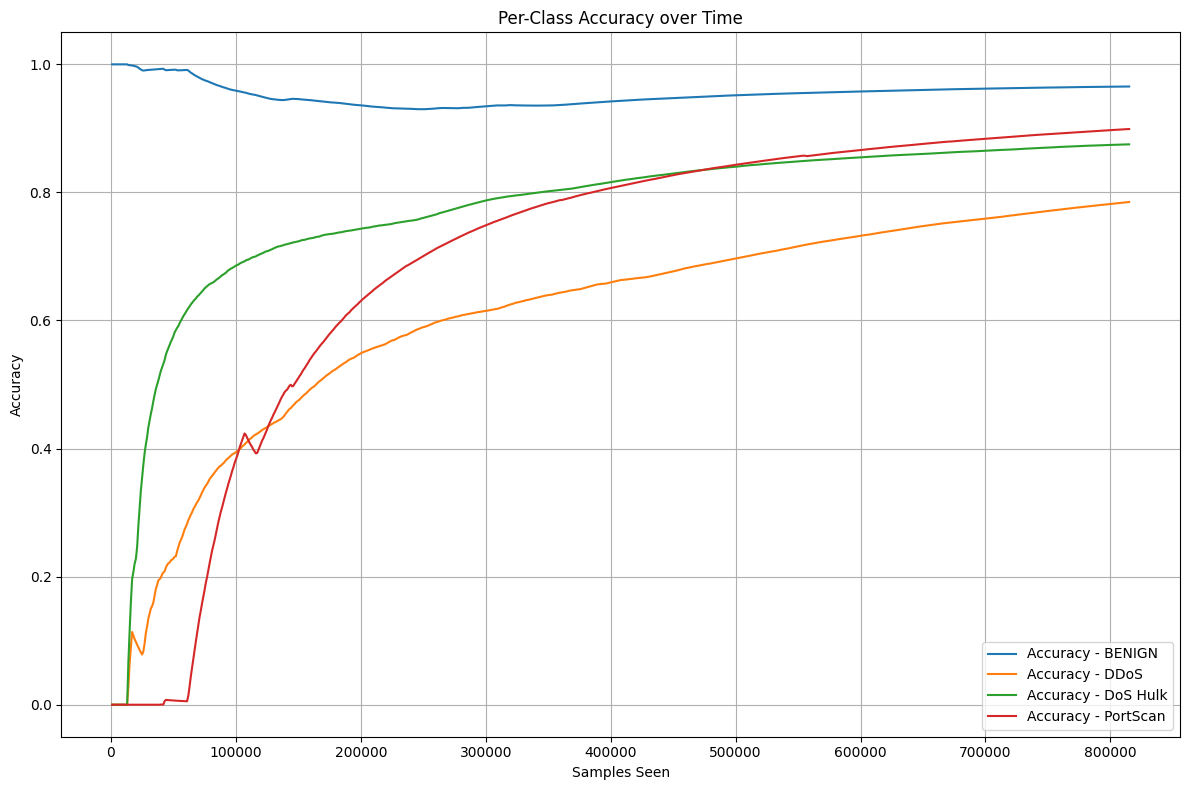

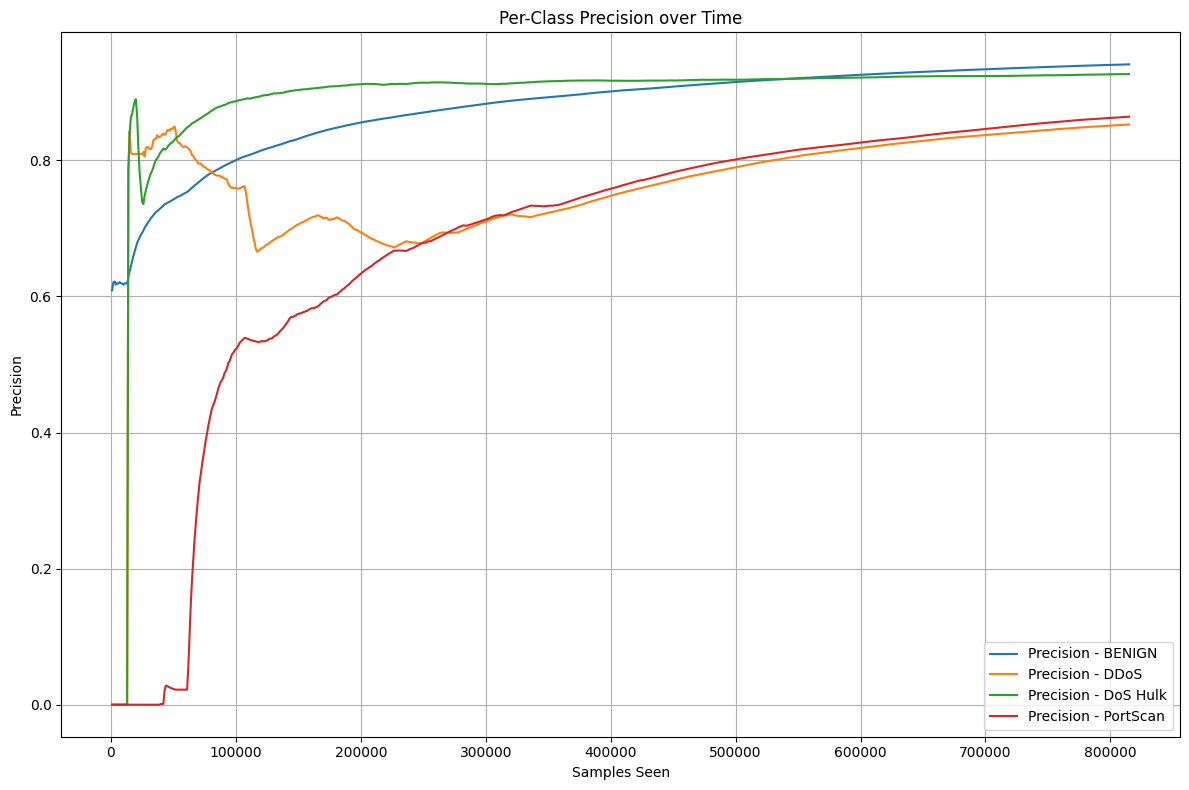

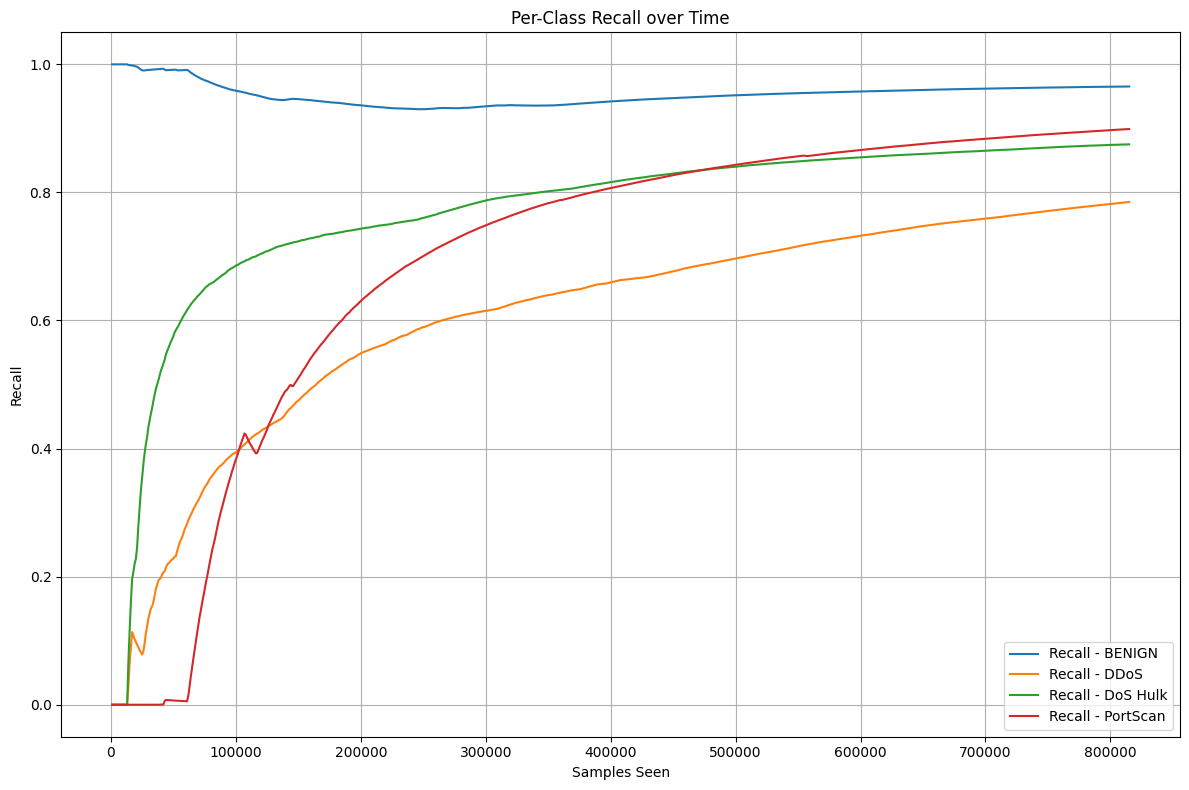

In [9]:
# Plot three metrics of training phase
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'accuracy')
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'precision')
plot_class_metric_over_time(class_metrics, steps, label_mapping, 'recall')

In [10]:
# Evaluation phase
test_acc = metrics.Accuracy()
test_precision = metrics.MacroPrecision()
test_recall = metrics.MacroRecall()
test_f1 = metrics.MacroF1()
test_cm = metrics.ConfusionMatrix()

for _, row in test_df.iterrows():
    x = row[selected_features_kbest].to_dict()
    y = row['Label']
    
    y_pred = model.predict_one(x)

    test_acc.update(y, y_pred)
    test_precision.update(y, y_pred)
    test_recall.update(y, y_pred)
    test_f1.update(y, y_pred)
    test_cm.update(y, y_pred)

print("\nTesting Results:")
print("Accuracy:", test_acc)
print("Precision (Macro):", test_precision)
print("Recall (Macro):", test_recall)
print("F1-score (Macro):", test_f1)
print("Confusion Matrix:\n", test_cm)


Testing Results:
Accuracy: Accuracy: 96.71%
Precision (Macro): MacroPrecision: 95.25%
Recall (Macro): MacroRecall: 95.42%
F1-score (Macro): MacroF1: 95.33%
Confusion Matrix:
       0.0       1.0      2.0      3.0     
0.0   123,667      733      324      746  
1.0       163   23,532    1,908        0  
2.0     1,590      997   31,982        1  
3.0       213       18        4   17,929  


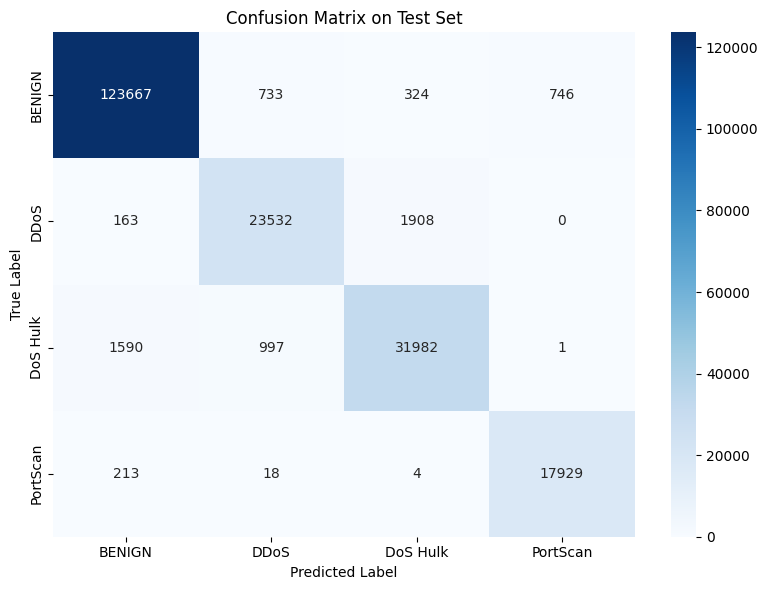

In [11]:
labels = list(label_mapping.values())  
label_names = list(label_mapping.keys()) 

# Initialize matrix 0
conf_matrix = np.zeros((len(labels), len(labels)), dtype=int)

# Take data from test_cm
for true_label in labels:
    for pred_label in labels:
        conf_matrix[true_label][pred_label] = test_cm[true_label][pred_label]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()